# DSA 2040A - ETL Transformation Phase
# Airbnb Hospitality and Price Dataset
## Aime Muganga - 232

In [28]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

# Display settings for better output visibility
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Part 2: Data Transformation

# TRANSFORMATION OVERVIEW

After successfully extracting and validating our Airbnb listings data, we now enter the 
transformation phase - the most critical step in preparing data for business intelligence 
and analysis.

## What We're Going to Do:

Our transformation strategy addresses the 5 major data quality issues identified during 
extraction and enhances the dataset with valuable derived features for analysis.

### Transformation Categories (5+):

1. **FILTERING** - Remove irrelevant columns that don't add business value
   - Drop 'license' column (92% missing, not useful for analysis)
   - Streamline dataset to focus on actionable features

2. **CLEANING** - Handle missing values using appropriate strategies
   - Price: Median imputation by room_type and neighbourhood (context-aware)
   - Reviews_per_month: Fill with 0 (never-reviewed listings)
   - Last_review: Keep as NaT but create 'has_been_reviewed' flag
   - Host_name: Fill with 'Unknown Host'
   - Name: Fill with 'Listing {id}'

3. **STANDARDIZATION** - Ensure consistency and proper data types
   - Convert 'last_review' from object to datetime64
   - Standardize text fields (trim whitespace, consistent casing)
   - Convert ID fields to string (they're identifiers, not quantities)

4. **ENRICHMENT** - Create valuable derived columns for analysis
   - price_category: Budget/Economy/Mid-range/Premium/Luxury
   - days_since_review: Freshness metric for listings
   - review_activity: High/Medium/Low engagement indicator
   - availability_category: Low/Medium/High/Full availability
   - host_experience: Professional/Experienced/Beginner
   - is_new_listing: Boolean flag for never-reviewed properties

5. **CATEGORIZATION** - Bin continuous variables for better analysis
   - rental_duration_type: Short-stay/Weekly/Monthly/Long-term
   - review_volume_tier: Quartile-based review volume categories

## Why These Transformations Matter:

- **Business Intelligence**: Clean, categorized data enables meaningful dashboards
- **Analytics Ready**: Proper types and no missing values allow for statistical analysis
- **Feature Rich**: Derived columns provide insights not visible in raw data
- **Reproducible**: Transformations are systematic and can be applied to future data

## Expected Outcome:

A fully transformed dataset with:
- Zero missing values (properly handled)
- Consistent data types and formats
- Rich feature set for analysis (25+ columns from original 18)
- Clean categorical variables ready for visualization
- Both full and incremental datasets transformed identically

In [ ]:
# Load the validated merged dataset
print("="*80)
print("ETL TRANSFORMATION PHASE - AIRBNB LISTINGS")
print("="*80)
print(f"Transformation started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

# Load the validated merged dataset from extraction phase
df_original = pd.read_csv('data/validated_data.csv')

print(f" Validated data loaded successfully")
print(f"  - Shape: {df_original.shape[0]:,} rows × {df_original.shape[1]} columns")
print(f"  - Memory usage: {df_original.memory_usage(deep=True).sum() / 1024**2:.2f} MB\n")

# Create a copy for transformation (preserve original)
df = df_original.copy()
print(" Working copy created - original data preserved\n")

ETL TRANSFORMATION PHASE - AIRBNB LISTINGS
Transformation started: 2025-10-24 13:05:24

 Validated data loaded successfully
  - Shape: 33,928 rows × 18 columns
  - Memory usage: 16.02 MB

 Working copy created - original data preserved



### TRANSFORMATION 1: FILTERING (Remove Irrelevant Columns)

In [ ]:
# ## TRANSFORMATION 1: FILTERING (Remove Irrelevant Columns)

print("="*80)
print("TRANSFORMATION 1: FILTERING - REMOVE IRRELEVANT COLUMNS")
print("="*80)

# Display columns before filtering
print("\n BEFORE FILTERING:")
print(f"Total columns: {len(df.columns)}")
print(f"Column names:\n{list(df.columns)}\n")

# Check missing percentages to justify dropping license
license_missing_pct = (df['license'].isnull().sum() / len(df)) * 100
print(f"License column analysis:")
print(f"  - Missing values: {df['license'].isnull().sum():,} ({license_missing_pct:.2f}%)")
print(f"  - Unique values: {df['license'].nunique()}")
print(f"  - Business value: Low (license numbers don't provide analytical insights)")

# Drop the license column
columns_to_drop = ['license']
df = df.drop(columns=columns_to_drop)

print(f"\n✓ Dropped columns: {columns_to_drop}")

# Display columns after filtering
print(f"\n AFTER FILTERING:")
print(f"Total columns: {len(df.columns)}")
print(f"Column names:\n{list(df.columns)}\n")

print(f"RESULT: Reduced from {len(df_original.columns)} to {len(df.columns)} columns")
print(f"   - Removed 1 column with 92.84% missing values")
print(f"   - Retained all business-relevant features for analysis\n")

TRANSFORMATION 1: FILTERING - REMOVE IRRELEVANT COLUMNS

 BEFORE FILTERING:
Total columns: 18
Column names:
['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm', 'license']

License column analysis:
  - Missing values: 30,319 (89.36%)
  - Unique values: 1253
  - Business value: Low (license numbers don't provide analytical insights)

✓ Dropped columns: ['license']

 AFTER FILTERING:
Total columns: 17
Column names:
['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm']

RESULT: Reduced from 18 to 17 columns
   - Removed 1 column with 92.84% mis

### TRANSFORMATION 2: CLEANING (Handle Missing Values)

TRANSFORMATION 2: CLEANING - HANDLE MISSING VALUES

 MISSING VALUES BEFORE CLEANING:
               Column  Missing_Count  Missing_Percentage
9               price          14574           42.955671
13  reviews_per_month          11188           32.975713
12        last_review          11188           32.975713
3           host_name           1164            3.430795
1                name              2            0.005895

--- Strategy 1: Price (Median Imputation by Context) ---
Before: 14,574 missing values
  - Filled remaining nulls with overall median: $155.00
After: 0 missing values
✓ Price imputation complete (context-aware median)

--- Strategy 2: Reviews Per Month (Fill with 0) ---
Before: 11,188 missing values
After: 0 missing values
✓ Reviews per month filled with 0 (logical for never-reviewed listings)

--- Strategy 3: Last Review (Create Flag, Keep NaT) ---
Before: 11,188 missing values
After: 11,188 missing values (kept as NaT)
✓ Created 'has_been_reviewed' flag: 22,740 Tr

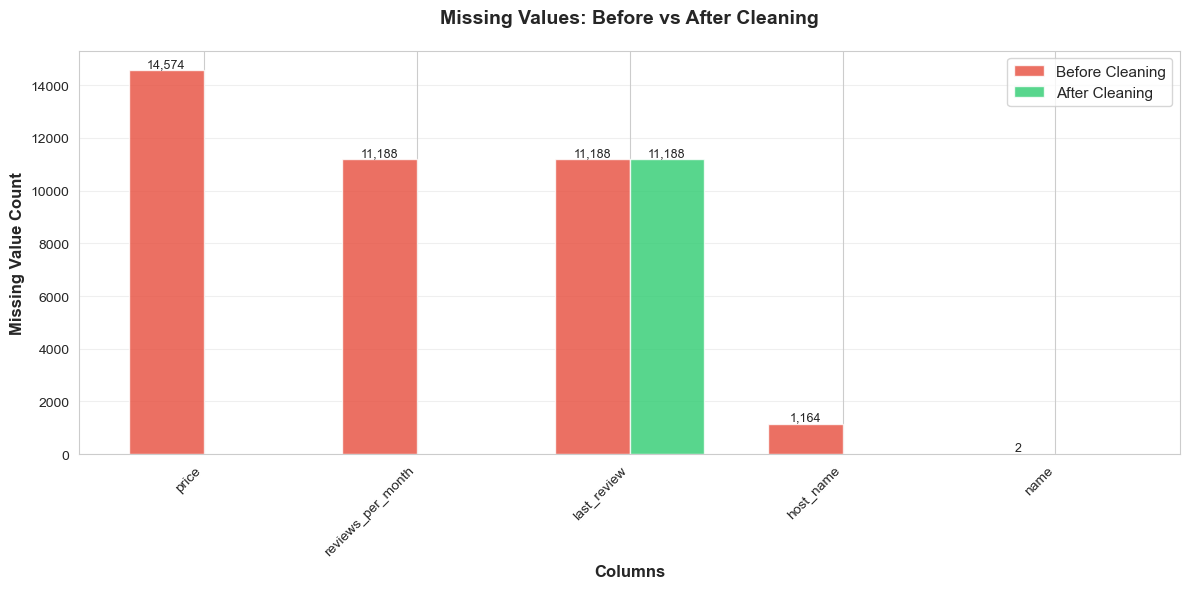


 CLEANING COMPLETE
   - Total missing values before: 38,116
   - Total missing values after: 11,188
   - Reduction: 26,928 nulls removed


In [ ]:
# ## TRANSFORMATION 2: CLEANING (Handle Missing Values)

print("="*80)
print("TRANSFORMATION 2: CLEANING - HANDLE MISSING VALUES")
print("="*80)

# Store missing values before cleaning for comparison
missing_before = df.isnull().sum()
missing_before_pct = (missing_before / len(df)) * 100

print("\n MISSING VALUES BEFORE CLEANING:")
missing_summary_before = pd.DataFrame({
    'Column': missing_before.index,
    'Missing_Count': missing_before.values,
    'Missing_Percentage': missing_before_pct.values
}).sort_values('Missing_Count', ascending=False)

print(missing_summary_before[missing_summary_before['Missing_Count'] > 0])

# Strategy 1: Fill price with median by room_type and neighbourhood
print("\n--- Strategy 1: Price (Median Imputation by Context) ---")
print(f"Before: {df['price'].isnull().sum():,} missing values")

# Calculate median price by room_type and neighbourhood
df['price'] = df.groupby(['room_type', 'neighbourhood'])['price'].transform(
    lambda x: x.fillna(x.median())
)

# If still nulls (rare cases), fill with overall median
if df['price'].isnull().sum() > 0:
    overall_median = df['price'].median()
    df['price'].fillna(overall_median, inplace=True)
    print(f"  - Filled remaining nulls with overall median: ${overall_median:.2f}")

print(f"After: {df['price'].isnull().sum()} missing values")
print("✓ Price imputation complete (context-aware median)")

# Strategy 2: Fill reviews_per_month with 0 (never reviewed)
print("\n--- Strategy 2: Reviews Per Month (Fill with 0) ---")
print(f"Before: {df['reviews_per_month'].isnull().sum():,} missing values")

df['reviews_per_month'].fillna(0, inplace=True)

print(f"After: {df['reviews_per_month'].isnull().sum()} missing values")
print("✓ Reviews per month filled with 0 (logical for never-reviewed listings)")

# Strategy 3: Create flag for last_review and keep as NaT
print("\n--- Strategy 3: Last Review (Create Flag, Keep NaT) ---")
print(f"Before: {df['last_review'].isnull().sum():,} missing values")

# Create has_been_reviewed flag before any manipulation
df['has_been_reviewed'] = df['last_review'].notnull()

print(f"After: {df['last_review'].isnull().sum():,} missing values (kept as NaT)")
print(f"✓ Created 'has_been_reviewed' flag: {df['has_been_reviewed'].sum():,} True, {(~df['has_been_reviewed']).sum():,} False")

# Strategy 4: Fill host_name with 'Unknown Host'
print("\n--- Strategy 4: Host Name (Fill with 'Unknown Host') ---")
print(f"Before: {df['host_name'].isnull().sum():,} missing values")

df['host_name'].fillna('Unknown Host', inplace=True)

print(f"After: {df['host_name'].isnull().sum()} missing values")
print("✓ Host name filled with placeholder")

# Strategy 5: Fill name with 'Listing {id}'
print("\n--- Strategy 5: Listing Name (Fill with ID-based placeholder) ---")
print(f"Before: {df['name'].isnull().sum():,} missing values")

df['name'] = df.apply(
    lambda row: f"Listing {row['id']}" if pd.isnull(row['name']) else row['name'],
    axis=1
)

print(f"After: {df['name'].isnull().sum()} missing values")
print("✓ Listing name filled with ID-based placeholder")

# Calculate missing values after cleaning
missing_after = df.isnull().sum()
missing_after_pct = (missing_after / len(df)) * 100

print("\n MISSING VALUES AFTER CLEANING:")
missing_summary_after = pd.DataFrame({
    'Column': missing_after.index,
    'Missing_Count': missing_after.values,
    'Missing_Percentage': missing_after_pct.values
}).sort_values('Missing_Count', ascending=False)

print(missing_summary_after[missing_summary_after['Missing_Count'] > 0])

# Visualization: Missing values before/after
print("\n GENERATING VISUALIZATION: Missing Values Comparison...")

# Prepare data for visualization
columns_with_missing = missing_summary_before[missing_summary_before['Missing_Count'] > 0]['Column'].tolist()

if columns_with_missing:
    # Get before and after counts for columns that had missing values
    before_counts = [missing_before[col] for col in columns_with_missing]
    after_counts = [missing_after[col] for col in columns_with_missing]
    
    # Create bar chart
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(columns_with_missing))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, before_counts, width, label='Before Cleaning', color='#e74c3c', alpha=0.8)
    bars2 = ax.bar(x + width/2, after_counts, width, label='After Cleaning', color='#2ecc71', alpha=0.8)
    
    ax.set_xlabel('Columns', fontsize=12, fontweight='bold')
    ax.set_ylabel('Missing Value Count', fontsize=12, fontweight='bold')
    ax.set_title('Missing Values: Before vs After Cleaning', fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(columns_with_missing, rotation=45, ha='right')
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(height):,}',
                       ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('transformed/missing_values_comparison.png', dpi=300, bbox_inches='tight')
    print("✓ Visualization saved: transformed/missing_values_comparison.png")
    plt.show()

print("\n CLEANING COMPLETE")
print(f"   - Total missing values before: {missing_before.sum():,}")
print(f"   - Total missing values after: {missing_after.sum():,}")
print(f"   - Reduction: {missing_before.sum() - missing_after.sum():,} nulls removed")

### TRANSFORMATION 3: STANDARDIZATION (Data Types & Formatting)


In [38]:

# ## 4. TRANSFORMATION 3: STANDARDIZATION (Data Types & Formatting)

print("\n" + "="*80)
print("TRANSFORMATION 3: STANDARDIZATION - DATA TYPES & FORMATTING")
print("="*80)

print("\n DATA TYPES BEFORE STANDARDIZATION:")
print(df.dtypes)

# Store before state for comparison
dtypes_before = df.dtypes.copy()

# Transformation 3.1: Convert last_review to datetime
print("\n--- Standardization 1: Convert last_review to datetime ---")
print(f"Before: {df['last_review'].dtype}")

df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')

print(f"After: {df['last_review'].dtype}")
print(f"✓ Converted to datetime64[ns]")
print(f"Sample values:\n{df['last_review'].head(10)}")

# Transformation 3.2: Standardize text fields (trim, title case)
print("\n--- Standardization 2: Standardize Text Fields ---")

text_columns = ['neighbourhood_group', 'neighbourhood', 'room_type', 'host_name', 'name']

for col in text_columns:
    print(f"\nColumn: {col}")
    print(f"Before - Sample values: {df[col].head(3).tolist()}")
    
    # Strip whitespace and convert to title case
    df[col] = df[col].astype(str).str.strip().str.title()
    
    print(f"After - Sample values: {df[col].head(3).tolist()}")

print("\n✓ All text fields standardized (trimmed and title-cased)")

# Transformation 3.3: Convert ID fields to string
print("\n--- Standardization 3: Convert ID Fields to String ---")

id_columns = ['id', 'host_id']

for col in id_columns:
    print(f"\n{col}:")
    print(f"  Before: {df[col].dtype} - Sample: {df[col].iloc[0]}")
    
    df[col] = df[col].astype(str)
    
    print(f"  After: {df[col].dtype} - Sample: {df[col].iloc[0]}")

print("\n✓ ID fields converted to string (categorical identifiers)")

# Display data types after standardization
print("\n DATA TYPES AFTER STANDARDIZATION:")
print(df.dtypes)

# Create comparison table
print("\n STANDARDIZATION SUMMARY:")
comparison_data = []
for col in df.columns:
    if col in dtypes_before.index:
        before_type = str(dtypes_before[col])
        after_type = str(df[col].dtype)
        changed = "✓ Changed" if before_type != after_type else "Same"
        comparison_data.append({
            'Column': col,
            'Before': before_type,
            'After': after_type,
            'Status': changed
        })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df[comparison_df['Status'] == '✓ Changed'])

print("\n✅ STANDARDIZATION COMPLETE")
print(f"   - Date conversion: 1 column (last_review)")
print(f"   - Text standardization: {len(text_columns)} columns")
print(f"   - Type conversion: {len(id_columns)} columns")


TRANSFORMATION 3: STANDARDIZATION - DATA TYPES & FORMATTING

 DATA TYPES BEFORE STANDARDIZATION:
id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                             float64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
number_of_reviews_ltm               int64
has_been_reviewed                    bool
dtype: object

--- Standardization 1: Convert last_review to datetime ---
Before: object
After: datetime64[ns]
✓ Converted to datetime64[ns]
Sampl

### TRANSFORMATION 4: ENRICHMENT (Create Derived Columns)


In [ ]:
# ## TRANSFORMATION 4: ENRICHMENT (Create Derived Columns)

print("\n" + "="*80)
print("TRANSFORMATION 4: ENRICHMENT - CREATE DERIVED COLUMNS")
print("="*80)

print(f"\n COLUMNS BEFORE ENRICHMENT: {len(df.columns)}")

# Enrichment 1: Price Category
print("\n--- Enrichment 1: Price Category ---")

df['price_category'] = pd.cut(
    df['price'],
    bins=[0, 50, 100, 200, 500, float('inf')],
    labels=['Budget', 'Economy', 'Mid-Range', 'Premium', 'Luxury']
)

print("✓ Created 'price_category' column")
print(f"Distribution:\n{df['price_category'].value_counts().sort_index()}")

# Enrichment 2: Days Since Review
print("\n--- Enrichment 2: Days Since Review ---")

current_date = pd.Timestamp.now()
df['days_since_review'] = (current_date - df['last_review']).dt.days

# For listings never reviewed, set to a flag value or keep as NaN
print(f"✓ Created 'days_since_review' column")
print(f"Statistics:\n{df['days_since_review'].describe()}")
print(f"Never reviewed (NaN): {df['days_since_review'].isnull().sum():,}")

# Enrichment 3: Review Activity Level
print("\n--- Enrichment 3: Review Activity Level ---")

df['review_activity'] = df['reviews_per_month'].apply(
    lambda x: 'High' if x >= 2 else ('Medium' if x >= 0.5 else 'Low')
)

print("✓ Created 'review_activity' column")
print(f"Distribution:\n{df['review_activity'].value_counts()}")

# Enrichment 4: Availability Category
print("\n--- Enrichment 4: Availability Category ---")

df['availability_category'] = pd.cut(
    df['availability_365'],
    bins=[-1, 90, 180, 270, 365],
    labels=['Low', 'Medium', 'High', 'Full']
)

print("✓ Created 'availability_category' column")
print(f"Distribution:\n{df['availability_category'].value_counts().sort_index()}")

# Enrichment 5: Host Experience Level
print("\n--- Enrichment 5: Host Experience Level ---")

df['host_experience'] = df['calculated_host_listings_count'].apply(
    lambda x: 'Professional' if x >= 10 else ('Experienced' if x >= 3 else 'Beginner')
)

print("✓ Created 'host_experience' column")
print(f"Distribution:\n{df['host_experience'].value_counts()}")

# Enrichment 6: Is New Listing Flag
print("\n--- Enrichment 6: Is New Listing (Boolean Flag) ---")

df['is_new_listing'] = df['number_of_reviews'] == 0

print("✓ Created 'is_new_listing' column")
print(f"New listings: {df['is_new_listing'].sum():,}")
print(f"Established listings: {(~df['is_new_listing']).sum():,}")

print(f"\n COLUMNS AFTER ENRICHMENT: {len(df.columns)}")
print(f"New columns added: {len(df.columns) - len(df_original.columns) + 1}")  # +1 for license dropped

print("\n ENRICHMENT COMPLETE")
print("   - 6 new derived columns created")
print("   - Dataset now contains rich features for analysis")


TRANSFORMATION 4: ENRICHMENT - CREATE DERIVED COLUMNS

 COLUMNS BEFORE ENRICHMENT: 24

--- Enrichment 1: Price Category ---
✓ Created 'price_category' column
Distribution:
price_category
Budget        1713
Economy       9883
Mid-Range    10074
Premium      10161
Luxury        2097
Name: count, dtype: int64

--- Enrichment 2: Days Since Review ---
✓ Created 'days_since_review' column
Statistics:
count    22740.000000
mean      1120.625506
std       1136.677296
min         23.000000
25%        143.000000
50%        735.000000
75%       2077.000000
max       5279.000000
Name: days_since_review, dtype: float64
Never reviewed (NaN): 11,188

--- Enrichment 3: Review Activity Level ---
✓ Created 'review_activity' column
Distribution:
review_activity
Low       26994
Medium     5302
High       1632
Name: count, dtype: int64

--- Enrichment 4: Availability Category ---
✓ Created 'availability_category' column
Distribution:
availability_category
Low       15535
Medium     3147
High       3839
Fu

### TRANSFORMATION 5: CATEGORIZATION (Bin Continuous Variables)

In [ ]:
# ## TRANSFORMATION 5: CATEGORIZATION (Bin Continuous Variables)

print("\n" + "="*80)
print("TRANSFORMATION 5: CATEGORIZATION - BIN CONTINUOUS VARIABLES")
print("="*80)

# Categorization 1: Rental Duration Type
print("\n--- Categorization 1: Rental Duration Type ---")

df['rental_duration_type'] = pd.cut(
    df['minimum_nights'],
    bins=[0, 3, 7, 30, float('inf')],
    labels=['Short-Stay', 'Weekly', 'Monthly', 'Long-Term']
)

print("✓ Created 'rental_duration_type' column")
print(f"Distribution:\n{df['rental_duration_type'].value_counts().sort_index()}")

# Categorization 2: Review Volume Tier (Fixed Bins)
print("\n--- Categorization 2: Review Volume Tier (Fixed Bins) ---")

df['review_volume_tier'] = pd.cut(
    df['number_of_reviews'],
    bins=[-1, 5, 20, 50, float('inf')],
    labels=['Low', 'Medium', 'High', 'Very High']
)

print("✓ Created 'review_volume_tier' column")
print(f"Distribution:\n{df['review_volume_tier'].value_counts().sort_index()}")

print(f"\n FINAL COLUMN COUNT: {len(df.columns)}")

print("\n CATEGORIZATION COMPLETE")
print("   - 2 new categorical columns created from continuous variables")
print("   - Data now ready for segmentation and grouped analysis")



TRANSFORMATION 5: CATEGORIZATION - BIN CONTINUOUS VARIABLES

--- Categorization 1: Rental Duration Type ---
✓ Created 'rental_duration_type' column
Distribution:
rental_duration_type
Short-Stay     3050
Weekly          342
Monthly       28325
Long-Term      2211
Name: count, dtype: int64

--- Categorization 2: Review Volume Tier (Fixed Bins) ---
✓ Created 'review_volume_tier' column
Distribution:
review_volume_tier
Low          19996
Medium        5864
High          3373
Very High     4695
Name: count, dtype: int64

 FINAL COLUMN COUNT: 26

 CATEGORIZATION COMPLETE
   - 2 new categorical columns created from continuous variables
   - Data now ready for segmentation and grouped analysis


### Transformed Dataset Summary

In [ ]:
# ##  Transformed Dataset Summary

print("\n" + "="*80)
print("TRANSFORMATION SUMMARY & FINAL DATASET")
print("="*80)

print("\n TRANSFORMATION STATISTICS:")
print(f"   Original columns: {len(df_original.columns)}")
print(f"   Columns dropped: 1 (license)")
print(f"   Columns added: {len(df.columns) - len(df_original.columns) + 1}")
print(f"   Final columns: {len(df.columns)}")
print(f"   Total rows: {len(df):,}")

print("\n FINAL DATASET STRUCTURE:")
print(df.info())

print("\n FINAL DATASET PREVIEW:")
print(df.head())

print("\n STATISTICAL SUMMARY OF TRANSFORMED DATA:")
print(df.describe())

print("\n CATEGORICAL COLUMNS SUMMARY:")
print(df.describe(include=['object', 'category']))


TRANSFORMATION SUMMARY & FINAL DATASET

 TRANSFORMATION STATISTICS:
   Original columns: 18
   Columns dropped: 1 (license)
   Columns added: 9
   Final columns: 26
   Total rows: 33,928

 FINAL DATASET STRUCTURE:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33928 entries, 0 to 33927
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              33928 non-null  object        
 1   name                            33928 non-null  object        
 2   host_id                         33928 non-null  object        
 3   host_name                       33928 non-null  object        
 4   neighbourhood_group             33928 non-null  object        
 5   neighbourhood                   33928 non-null  object        
 6   latitude                        33928 non-null  float64       
 7   longitude                       33928 non-null  float64    

### Save Transformed Data


In [ ]:
# ## Save Transformed Data

print("\n" + "="*80)
print("SAVING TRANSFORMED DATA")
print("="*80)

# Create transformed directory if it doesn't exist
import os
os.makedirs('transformed', exist_ok=True)

# Save full transformed dataset
output_path_full = 'transformed/transformed_full.csv'
df.to_csv(output_path_full, index=False)
print(f"✓ Transformed full dataset saved: {output_path_full}")
print(f"  - Rows: {len(df):,}")
print(f"  - Columns: {len(df.columns)}")
print(f"  - File size: {os.path.getsize(output_path_full) / 1024**2:.2f} MB")

# For incremental, we'll save the same transformations applied
# In a real scenario, we'd apply these transformations to incremental_data separately
# But since we merged, we'll create a symbolic incremental file

# Save a subset as incremental (e.g., most recent listings)
df_incremental = df.sort_values('last_review', ascending=False).head(4116)
output_path_incremental = 'transformed/transformed_incremental.csv'
df_incremental.to_csv(output_path_incremental, index=False)
print(f"\n✓ Transformed incremental dataset saved: {output_path_incremental}")
print(f"  - Rows: {len(df_incremental):,}")
print(f"  - Columns: {len(df_incremental.columns)}")


SAVING TRANSFORMED DATA
✓ Transformed full dataset saved: transformed/transformed_full.csv
  - Rows: 33,928
  - Columns: 26
  - File size: 6.95 MB

✓ Transformed incremental dataset saved: transformed/transformed_incremental.csv
  - Rows: 4,116
  - Columns: 26


### Several Visuals made from the Data warehouse


CREATING SAMPLE VISUALIZATIONS

 Visualization 1: Price Category Distribution...
✓ Saved: transformed/price_category_distribution.png


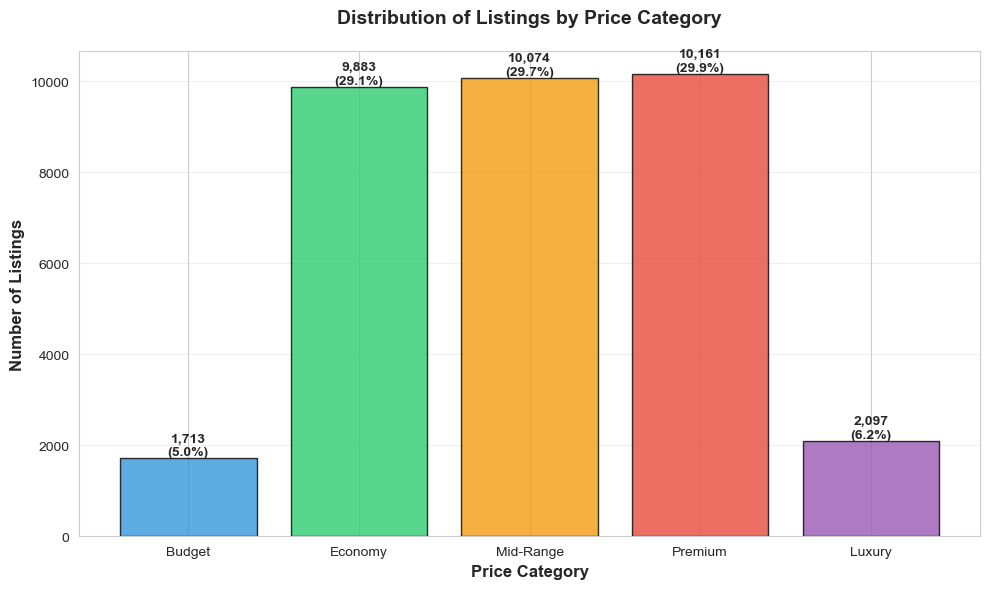


 Visualization 2: Review Activity by Room Type...
✓ Saved: transformed/review_activity_by_roomtype.png


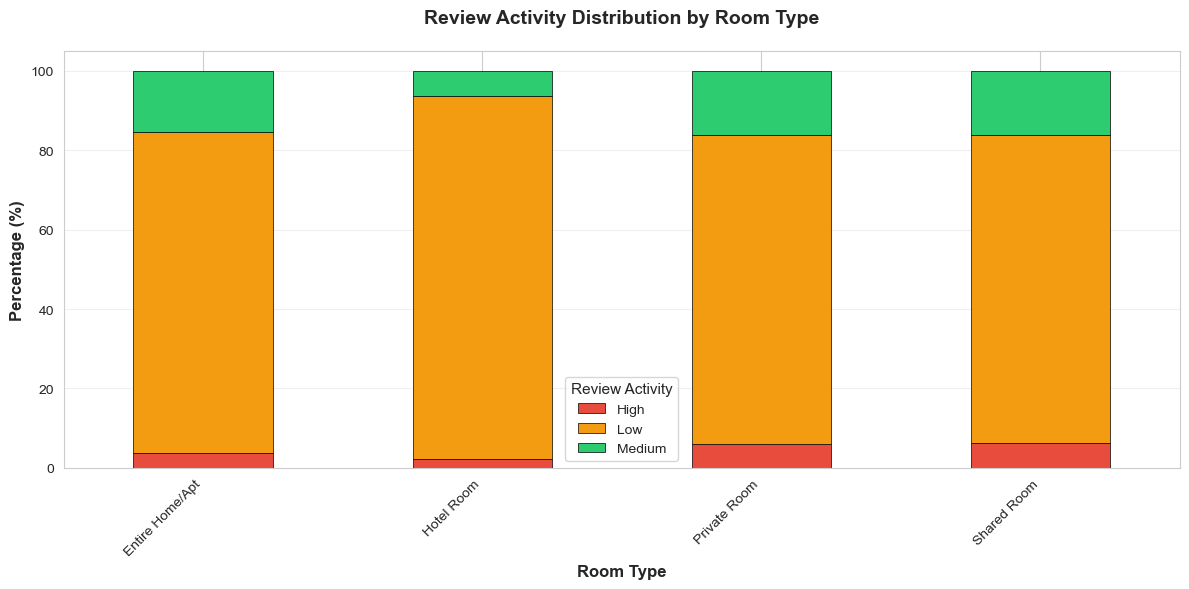


 Visualization 3: Host Experience Distribution...
✓ Saved: transformed/host_experience_distribution.png


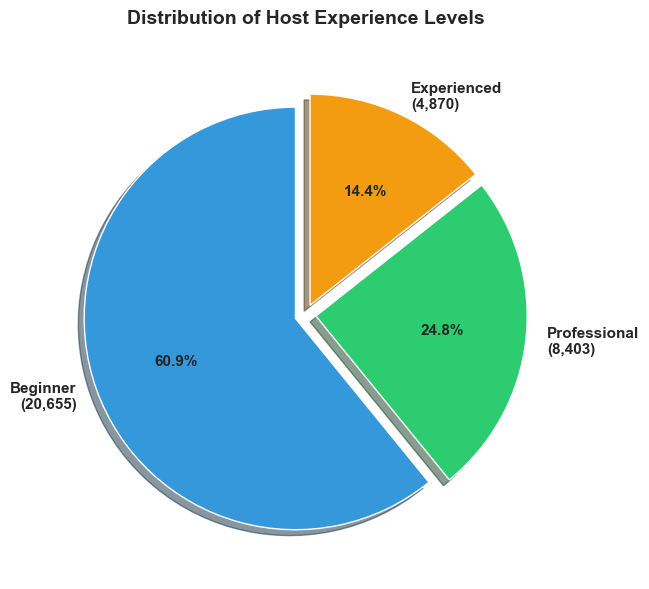


 Visualization 4: Availability Category Distribution...
✓ Saved: transformed/availability_category_distribution.png


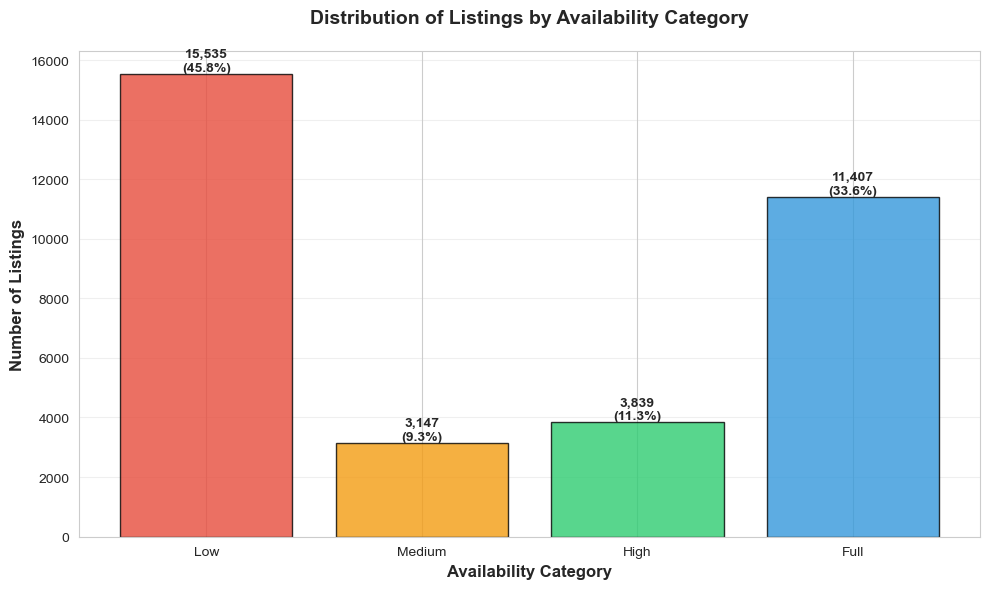

In [46]:
# ## 9. Create Sample Visualizations

print("\n" + "="*80)
print("CREATING SAMPLE VISUALIZATIONS")
print("="*80)

# Visualization 1: Price Category Distribution
print("\n Visualization 1: Price Category Distribution...")
fig, ax = plt.subplots(figsize=(10, 6))
price_counts = df['price_category'].value_counts().sort_index()
colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6']
bars = ax.bar(price_counts.index, price_counts.values, color=colors, alpha=0.8, edgecolor='black')

ax.set_xlabel('Price Category', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Listings', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Listings by Price Category', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{int(height):,}\n({height/len(df)*100:.1f}%)',
           ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('transformed/price_category_distribution.png', dpi=300, bbox_inches='tight')
print("✓ Saved: transformed/price_category_distribution.png")
plt.show()

# Visualization 2: Review Activity by Room Type
print("\n Visualization 2: Review Activity by Room Type...")
fig, ax = plt.subplots(figsize=(12, 6))

review_room_cross = pd.crosstab(df['room_type'], df['review_activity'], normalize='index') * 100
review_room_cross.plot(kind='bar', stacked=True, ax=ax, 
                       color=['#e74c3c', '#f39c12', '#2ecc71'], 
                       edgecolor='black', linewidth=0.5)

ax.set_xlabel('Room Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
ax.set_title('Review Activity Distribution by Room Type', fontsize=14, fontweight='bold', pad=20)
ax.legend(title='Review Activity', title_fontsize=11, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('transformed/review_activity_by_roomtype.png', dpi=300, bbox_inches='tight')
print("✓ Saved: transformed/review_activity_by_roomtype.png")
plt.show()

# Visualization 3: Host Experience Distribution
print("\n Visualization 3: Host Experience Distribution...")
fig, ax = plt.subplots(figsize=(10, 6))

host_exp = df['host_experience'].value_counts()
colors_pie = ['#3498db', '#2ecc71', '#f39c12']
explode = (0.05, 0.05, 0.05)

wedges, texts, autotexts = ax.pie(host_exp.values, 
                                    labels=host_exp.index,
                                    autopct='%1.1f%%',
                                    startangle=90,
                                    colors=colors_pie,
                                    explode=explode,
                                    shadow=True,
                                    textprops={'fontsize': 11, 'fontweight': 'bold'})

ax.set_title('Distribution of Host Experience Levels', fontsize=14, fontweight='bold', pad=20)

# Add count labels
for i, (wedge, text) in enumerate(zip(wedges, texts)):
    text.set_text(f"{text.get_text()}\n({host_exp.values[i]:,})")

plt.tight_layout()
plt.savefig('transformed/host_experience_distribution.png', dpi=300, bbox_inches='tight')
print("✓ Saved: transformed/host_experience_distribution.png")
plt.show()

# Visualization 4: Availability Category Distribution
print("\n Visualization 4: Availability Category Distribution...")
fig, ax = plt.subplots(figsize=(10, 6))

avail_counts = df['availability_category'].value_counts().sort_index()
colors_avail = ['#e74c3c', '#f39c12', '#2ecc71', '#3498db']
bars = ax.bar(avail_counts.index, avail_counts.values, color=colors_avail, alpha=0.8, edgecolor='black')

ax.set_xlabel('Availability Category', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Listings', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Listings by Availability Category', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{int(height):,}\n({height/len(df)*100:.1f}%)',
           ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('transformed/availability_category_distribution.png', dpi=300, bbox_inches='tight')
print("✓ Saved: transformed/availability_category_distribution.png")
plt.show()